# Collaborative Filtering Embedding

Now we will take advantage of the user interactions to represent movies in an embedding space. We don't need any movie attribute here, only the user ratings.

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from lightfm import LightFM
from sklearn.preprocessing import normalize

from src.factorization import describe_csr_matrix

## Building the Utility Matrix

First of all, we need to put data into an user/movie matrix format. Users will be represented as rows, movies as columns and like(+1)/dislike(-1) as values.

In [2]:
ratings = pd.read_csv('data/movie_ratings.csv', index_col='id')
movies = pd.read_csv('data/movie_info.csv', usecols=['id','title'], index_col='id')

ratings = ratings.join(movies, how='inner')
ratings.reset_index(drop=False, inplace=True)

ratings.head()

/home/recommender/anaconda3/envs/movie-similarity/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,id,user,rating,title
0,2,4,4.0,Jumanji
1,2,14,4.0,Jumanji
2,2,39,3.5,Jumanji
3,2,42,3.0,Jumanji
4,2,45,0.5,Jumanji


We need to convert idss to indexes in order to crete the sparse matrix:

In [3]:
ratings['user_idx'] = ratings['user'].astype('category').cat.codes
ratings['movie_idx'] = ratings['id'].astype('category').cat.codes

ratings.head()

,id,user,rating,title,user_idx,movie_idx
0,2,4,4.0,Jumanji,3,0
1,2,14,4.0,Jumanji,12,0
2,2,39,3.5,Jumanji,35,0
3,2,42,3.0,Jumanji,37,0
4,2,45,0.5,Jumanji,40,0


Ratings above 3.5 will be considered as likes (+1) and the remaining ones as dislikes (-1):

In [4]:
ratings['value'] = np.where(ratings['rating'] >= 3.5, 1.0, -1.0)
ratings['value'].value_counts()

 1.0    15810170
-1.0     9643061
Name: value, dtype: int64

So we will crete a +1/-1 sparse matrix to represent user interactions with the movies:

In [5]:
values = ratings['value'].values
idx = (ratings.user_idx.values, ratings.movie_idx.values,)
dim = (ratings.user_idx.max()+1, ratings.movie_idx.max()+1)
x = coo_matrix((values, idx), shape=dim)

print(describe_csr_matrix(x))

273627 x 10698 sparse matrix with 99.13% of sparsity.


## Factorizing the Utility Matrix

By factorizing the utility matrix we will get user factors and movie factors. The last ones will be used as embedding features to represent movies. As in the content based approach, we will get 300 factors:

In [6]:
%%time

N_COMPONENTS = 300
lfm = LightFM(no_components=N_COMPONENTS, loss='logistic', random_state=0)
lfm.fit(x, epochs=5, num_threads=8, verbose=False)

CPU times: user 33min 13s, sys: 1.06 s, total: 33min 14s
Wall time: 4min 17s


Since we have +1/-1 values, we applied a Logistic Loss. Then, we can extract movie factors and bias:

In [7]:
movie_bias, movie_embedding = lfm.get_item_representations()
movie_embedding = normalize(movie_embedding, norm="l2", axis=1, copy=False)

print(movie_embedding.shape)
print(movie_embedding[:5, :5])

(10698, 300)
[[ 0.13717581 -0.03386943 -0.03017038  0.05062018  0.03954934]
 [ 0.03843264  0.02700372 -0.01565084  0.02153345 -0.09214582]
 [ 0.07393657 -0.06563244 -0.05454138  0.03856608  0.0649413 ]
 [ 0.05018987 -0.07951837 -0.03726879  0.05435565 -0.09216952]
 [ 0.00977158  0.00257648 -0.04626083 -0.03330302 -0.04443587]]


Let's check the bias term against the number of votes, number of likes and average rating:

In [8]:
%%time

ratings['like'] = np.where(ratings['rating'] >= 3.5, 1.0, 0.0)
ratings['dislike'] = np.where(ratings['rating'] < 3.5, 1.0, 0.0)

movie_votes = ratings.groupby(['id']).agg(
    title = pd.NamedAgg(column='title', aggfunc='first'),
    num_votes = pd.NamedAgg(column='user_idx', aggfunc='count'),
    num_likes = pd.NamedAgg(column='like', aggfunc='sum'),
    num_dislikes = pd.NamedAgg(column='dislike', aggfunc='sum'),
    avg_rating = pd.NamedAgg(column='rating', aggfunc='mean'),
).reset_index(drop=False)
movie_votes['bias'] = movie_bias

movie_votes.head()

CPU times: user 3.46 s, sys: 1.57 s, total: 5.03 s
Wall time: 4.63 s


,id,title,num_votes,num_likes,num_dislikes,avg_rating,bias
0,2,Jumanji,27138,12345.0,14793.0,3.246499,-0.311027
1,3,Grumpier Old Men,15579,5861.0,9718.0,3.173792,-0.631766
2,4,Waiting to Exhale,2989,848.0,2141.0,2.874540,-0.952873
3,5,Father of the Bride Part II,15466,5064.0,10402.0,3.077169,-1.132931
4,6,Heat,28680,20049.0,8631.0,3.844125,0.970788


<AxesSubplot:xlabel='num_votes', ylabel='bias'>

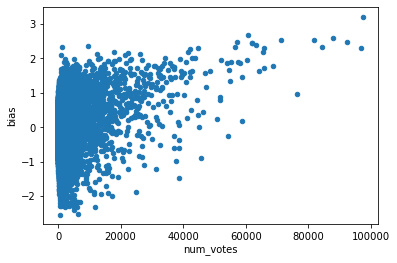

In [9]:
movie_votes.plot.scatter(x='num_votes', y='bias')

<AxesSubplot:xlabel='num_likes', ylabel='bias'>

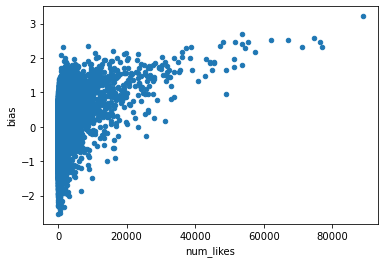

In [10]:
movie_votes.plot.scatter(x='num_likes', y='bias')

<AxesSubplot:xlabel='num_dislikes', ylabel='bias'>

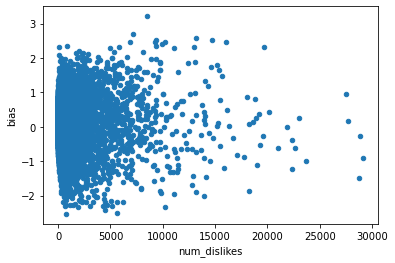

In [11]:
movie_votes.plot.scatter(x='num_dislikes', y='bias')

<AxesSubplot:xlabel='avg_rating', ylabel='bias'>

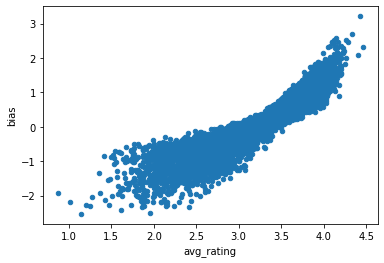

In [12]:
movie_votes.plot.scatter(x='avg_rating', y='bias')

We can observe a strong correlation between average rating and the bias term learned in the factorization step.

## Visualizing the Embedding Space

Let's check the learned factors using the Embedding Projector:

In [13]:
%%time

movie_votes[['id','title']].to_csv('output/cb_embedding_meta.tsv', sep='\t', header=True, index=False)
pd.DataFrame(movie_embedding).to_csv('output/collab_filt_vectors.tsv', sep='\t', 
                                     float_format='%.5f', header=False, index=False)

CPU times: user 4.6 s, sys: 168 ms, total: 4.77 s
Wall time: 4.76 s


![](img/collab_filt_lord_rings.png)

![](img/collab_filt_star_wars.png)

![](img/collab_filt_pulp_fiction.png)